In [3]:
"""
Avellaneda-Stoikov style market making (discrete approximation)

Class AvellanedaMM:
- update_market(mid_price, timestamp)
- quote() -> (bid_price, bid_size, ask_price, ask_size)
- on_trade(side, size, price)  # inform the MM it got filled
- step(dt)  # optional time step for decay / horizon

Example usage at bottom.
"""

import math
import time

class AvellanedaMM:
    def __init__(self,
                 gamma=0.1,        # risk aversion
                 sigma=0.02,       # (annualized) volatility estimate (in price units)
                 k=1.5,            # order arrival sensitivity (higher -> more passive spreads)
                 A=140.0,          # base intensity (liquidity) parameter
                 inventory_limit=10,
                 position_size=1,
                 horizon=1.0        # time horizon (in same time units as sigma) used in formula
                 ):
        """
        Parameters:
          gamma: risk aversion (higher -> quotes closer to mid but smaller inventory exposure)
          sigma: volatility (annualized or consistent time unit)
          k, A: intensity parameters for exponential fill probability model:
                lambda(delta) = A * exp(-k * delta)
          inventory_limit: max absolute inventory allowed
          position_size: default order size quoted on each side
          horizon: time horizon remaining (used for reservation price & spread)
        """
        self.gamma = gamma
        self.sigma = sigma
        self.k = k
        self.A = A
        self.inventory_limit = inventory_limit
        self.position_size = position_size
        self.horizon = horizon

        # state
        self.mid = None
        self.t = 0.0  # current time (arbitrary units)
        self.inventory = 0.0
        self.cash = 0.0
        self.pnl = 0.0
        self.history = []  # store quotes / trades for analysis

    # ---- core model formulas (Avellaneda-Stoikov discrete form) ----
    def reservation_price(self):
        """
        Reservation price r_t = S_t - q_t * gamma * sigma^2 * (T - t)
        (S_t = mid price)
        """
        if self.mid is None:
            raise RuntimeError("mid price unknown")
        return self.mid - self.inventory * self.gamma * (self.sigma ** 2) * self.horizon

    def optimal_half_spread(self):
        """
        A commonly used closed form for optimal half spread (delta*):
          delta* = (gamma * sigma^2 * horizon / 2) + (1/gamma) * ln(1 + gamma/k)
        This is the discrete-approx form used in many implementations.
        Note: different papers/implementations use slightly different constant terms.
        """
        term1 = 0.5 * self.gamma * (self.sigma ** 2) * self.horizon
        # ensure k non-zero
        if self.k <= 0:
            term2 = 0.0
        else:
            # avoid negative/zero inside log
            term2 = (1.0 / self.gamma) * math.log(1.0 + self.gamma / self.k)
        return term1 + term2

    # ---- public API ----
    def update_market(self, mid_price, timestamp=None):
        """Update the mid (market) price and optional time"""
        self.mid = float(mid_price)
        if timestamp is not None:
            self.t = float(timestamp)

    def quote(self):
        """
        Return (bid_price, bid_size, ask_price, ask_size).
        We clip inventory to inventory_limit by shifting quotes or disabling one side.
        """
        r = self.reservation_price()
        half_spread = self.optimal_half_spread()

        bid = r - half_spread
        ask = r + half_spread

        # inventory control: if inventory too long, skew quotes to encourage sells (wider ask / tighter bid)
        # simple rule: if inventory > 0, move both quotes down by alpha*inventory
        inventory_skew = 0.0
        alpha = 0.02  # tuning parameter: how aggressively to skew per unit inventory
        inventory_skew = alpha * self.inventory

        bid -= inventory_skew
        ask -= inventory_skew

        # limit inventories: if beyond limit, disable the side that increases exposure
        bid_size = self.position_size
        ask_size = self.position_size
        if self.inventory >= self.inventory_limit:
            # too long, don't post bids
            bid = None
            bid_size = 0
        if self.inventory <= -self.inventory_limit:
            # too short, don't post asks
            ask = None
            ask_size = 0

        # record quote for debugging / analysis
        self.history.append({
            'time': self.t,
            'mid': self.mid,
            'inventory': self.inventory,
            'reservation': r,
            'half_spread': half_spread,
            'bid': bid,
            'ask': ask
        })

        return bid, bid_size, ask, ask_size

    def on_trade(self, side, size, price):
        """
        Inform the MM that an order executed.
        side: 'buy' or 'sell' from MM's perspective:
          - 'buy' means MM bought (so inventory increases)
          - 'sell' means MM sold (inventory decreases)
        price: execution price
        size: executed size
        """
        if side not in ('buy', 'sell'):
            raise ValueError("side must be 'buy' or 'sell'")

        if side == 'buy':
            self.inventory += size
            self.cash -= price * size
        else:
            self.inventory -= size
            self.cash += price * size

        # update P&L mark-to-market
        if self.mid is not None:
            self.pnl = self.cash + self.inventory * self.mid

        self.history.append({
            'time': self.t,
            'trade': {'side': side, 'size': size, 'price': price},
            'inventory': self.inventory,
            'cash': self.cash,
            'pnl': self.pnl
        })

    def step(self, dt):
        """Advance time horizon (simple): reduce horizon by dt"""
        self.horizon = max(0.0, self.horizon - dt)
        self.t += dt

    # utility for diagnostics
    def snapshot(self):
        return {
            'time': self.t,
            'mid': self.mid,
            'inventory': self.inventory,
            'cash': self.cash,
            'pnl': self.pnl,
            'horizon': self.horizon
        }

# ---------------------------
# Example simple simulation
# ---------------------------
if __name__ == "__main__":
    import random

    mm = AvellanedaMM(gamma=0.1, sigma=0.02, k=1.2, A=120.0, inventory_limit=5, position_size=1, horizon=1.0)
    mm.update_market(mid_price=100.0, timestamp=0.0)

    # naive simulation: at each step, we get a mid price move and sample fills probabilistically:
    for i in range(200):
        # small mid price random walk
        mid_move = random.gauss(0, mm.sigma * math.sqrt(1/252/24/60))  # example small step (very rough)
        new_mid = mm.mid + mid_move
        mm.update_market(new_mid, timestamp=i * 0.01)

        bid, bid_size, ask, ask_size = mm.quote()

        # simulate fill probabilities using lambda(delta) = A * exp(-k * delta)
        # if quote is None (disabled), no fills.
        if bid is not None:
            delta_bid = max(0.0001, mm.mid - bid)
            lambda_bid = mm.A * math.exp(-mm.k * delta_bid)
            # Poisson approx: prob of at least one fill in dt ~ 1 - exp(-lambda * dt)
            prob_fill_bid = 1.0 - math.exp(-lambda_bid * 0.01)
            if random.random() < prob_fill_bid:
                mm.on_trade('buy', bid_size, bid)

        if ask is not None:
            delta_ask = max(0.0001, ask - mm.mid)
            lambda_ask = mm.A * math.exp(-mm.k * delta_ask)
            prob_fill_ask = 1.0 - math.exp(-lambda_ask * 0.01)
            if random.random() < prob_fill_ask:
                mm.on_trade('sell', ask_size, ask)

        mm.step(0.01)

    print("Final snapshot:", mm.snapshot())
    # you can inspect mm.history for analysis


Final snapshot: {'time': 2.0, 'mid': 99.99953593900595, 'inventory': -1.0, 'cash': 227.82972936067398, 'pnl': 127.83019342166803, 'horizon': 0.0}


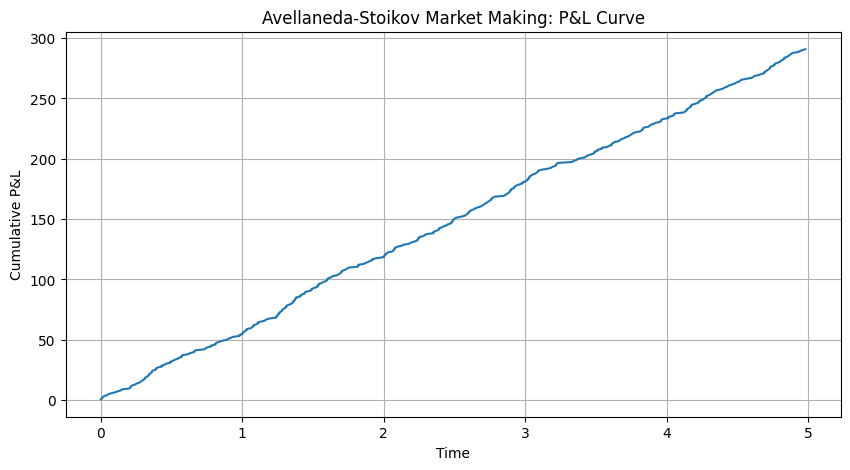

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import math, random

# --- 複製之前的 AvellanedaMM class 定義（省略此處以節省篇幅） ---
# 假設你已經定義過上面的 AvellanedaMM 類別

# 初始化做市模型
mm = AvellanedaMM(gamma=0.1, sigma=0.02, k=1.2, A=120.0,
                  inventory_limit=5, position_size=1, horizon=1.0)
mm.update_market(mid_price=100.0, timestamp=0.0)

# 模擬市場與做市過程
for i in range(500):  # 多跑一點步數讓曲線更平滑
    mid_move = random.gauss(0, mm.sigma * math.sqrt(1/252/24/60))
    new_mid = mm.mid + mid_move
    mm.update_market(new_mid, timestamp=i * 0.01)

    bid, bid_size, ask, ask_size = mm.quote()

    if bid is not None:
        delta_bid = max(0.0001, mm.mid - bid)
        lambda_bid = mm.A * math.exp(-mm.k * delta_bid)
        prob_fill_bid = 1.0 - math.exp(-lambda_bid * 0.01)
        if random.random() < prob_fill_bid:
            mm.on_trade('buy', bid_size, bid)

    if ask is not None:
        delta_ask = max(0.0001, ask - mm.mid)
        lambda_ask = mm.A * math.exp(-mm.k * delta_ask)
        prob_fill_ask = 1.0 - math.exp(-lambda_ask * 0.01)
        if random.random() < prob_fill_ask:
            mm.on_trade('sell', ask_size, ask)

    mm.step(0.01)

# --- 轉成 DataFrame 繪圖 ---
df = pd.DataFrame(mm.history)
# 取出有 pnl 欄位的紀錄
df_pnl = df.dropna(subset=["pnl"])

plt.figure(figsize=(10,5))
plt.plot(df_pnl["time"], df_pnl["pnl"], lw=1.5)
plt.title("Avellaneda-Stoikov Market Making: P&L Curve")
plt.xlabel("Time")
plt.ylabel("Cumulative P&L")
plt.grid(True)
plt.show()
